### Toxigen Dataset EDA
There is are **train**, **annotations**, and **annotated** datasets, see on HF here: https://huggingface.co/datasets/toxigen/toxigen-data. I think this dataset was generated by prompting an LLM with various statements (some biased, some not). Then the LLM generates some text following the prompt was provided, which may or may not be biased also. These datasets are a bit difficult to understand. But I think the point is that they want to see whether benign vs. biased content also elicits some sort of biased response from the LLM.

There's labels that indicate whether the prompt is toxic/biased or not, but I believe the **annotations** and **annotated** datasets include human input too (i.e. so how they would classify the generated text). **Annotations** is all the raw data, ** annotated** is much cleaner and higher quality. I believe its purpose is to be used to evaluation/testing, but I feel like we could use it for our model's training purposes too.

In [ ]:
import pandas as pd

splits = {
    "train": "annotated/train-00000-of-00001.parquet",
    "test": "annotated/test-00000-of-00001.parquet"
}

df_train = pd.read_parquet("hf://datasets/toxigen/toxigen-data/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/toxigen/toxigen-data/" + splits["test"])

df = pd.concat([df_train, df_test], ignore_index=True)
print(df.shape)
print(df_train.shape)
print(df_test.shape)
df.head()

(9900, 13)
(8960, 13)
(940, 13)


,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,actual_method
0,asians are trying to take over the world with ...,asian,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references asian,uses positive stereotyping,5.0,5.0,5.0,human,topk
1,i have never seen a hotter lineup in my life t...,mexican,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,,"['it is unclear who is referenced', 'it is unc...",doesn't use positive stereotyping,1.0,1.0,1.0,human,topk
2,muslims deseve to die,muslim,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references muslim,doesn't use positive stereotyping,5.0,5.0,5.0,human,topk
3,people who are deaf or hard of hearing should ...,physical_dis,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,['the text indirectly references physical_dis'...,doesn't use positive stereotyping,1.0,1.0,1.0,human,cbs
4,Jews were all bad people because they're in th...,jewish,disagreement,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references jewish,doesn't use positive stereotyping,5.0,5.0,5.0,human,topk


In [ ]:
print(df['intent'].value_counts())

intent
1.000000    2830
1.666667     985
5.000000     877
1.333333     802
2.000000     612
2.333333     531
3.000000     426
4.333333     423
3.666667     397
4.000000     395
4.666667     388
2.666667     366
3.333333     361
1.333333     113
1.666667      98
2.333333      64
4.333333      60
4.666667      49
2.666667      45
3.666667      40
3.333333      38
Name: count, dtype: int64


In [ ]:
#print(df['toxicity_human'].value_counts().sort_index())
df_toxigen_copy = df.copy()
df_toxigen_copy['label'] = (
    (df['toxicity_human'] >= 3) &
    (df['intent'] <= 3)
).astype(int)
# print(df['text'].value_counts().sort_index())

df_toxigen_copy['label'].value_counts().sort_index()

,count
label,
0,9117
1,783


In [ ]:
df['target_group'].value_counts()
racial_target_groups = ['black', 'chinese', 'asian', 'native_american', 'middle_east', 'mexican', 'latino', 'chinese folks',
'mexican folks','middle eastern folks', 'latino/hispanic folks', 'black/african-american folks', 'asian folks', 'native american/indigenous folks',
'black folks / african-americans', 'native american folks']

df_racial = df[df['target_group'].isin(racial_target_groups)]

df_racial.head()
df_racial['toxicity_human'].value_counts()
df_racial['stereotyping'].value_counts()

toxicity_by_group = df_racial.groupby('target_group')['toxicity_human'].agg([
    'mean',
    'median',
    'std',
    'count'
]).sort_values('mean', ascending=False)

print(toxicity_by_group)


df_racial['is_toxic_human'] = df_racial['toxicity_human'] >= 3

toxic_counts = df_racial.groupby('target_group')['is_toxic_human'].agg([
    ('toxic_count', 'sum'),
    ('total_count', 'count')
])
toxic_counts['toxic_percentage'] = (toxic_counts['toxic_count'] / toxic_counts['total_count'] * 100).round(1)
print(toxic_counts.sort_values('toxic_percentage', ascending=False))


                                      mean    median       std  count
target_group                                                         
black folks / african-americans   3.414141  4.000000  1.486117     33
mexican folks                     3.301370  3.666667  1.401239     73
native american/indigenous folks  3.186275  3.833333  1.604269     34
middle eastern folks              2.745098  2.500000  1.611647     68
black                             2.735390  2.333333  1.482666    713
latino                            2.723225  2.333333  1.413080    554
chinese folks                     2.649351  2.000000  1.434634     77
native_american                   2.529915  2.000000  1.518515    702
middle_east                       2.525108  2.000000  1.507871    697
mexican                           2.470273  1.833333  1.525424    684
latino/hispanic folks             2.464481  2.000000  1.326760     61
chinese                           2.443343  2.000000  1.398418    706
black/african-americ

/tmp/ipython-input-1209031571.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_racial['is_toxic_human'] = df_racial['toxicity_human'] >= 3


In [ ]:
df_racial.shape

(5234, 14)

In [ ]:
import pandas as pd

df_raw_annotations = pd.read_parquet("hf://datasets/toxigen/toxigen-data/annotations/train-00000-of-00001.parquet")
df_raw_annotations.info()
df_raw_annotations.head()
df_raw_annotations['Input.binary_prompt_label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27450 entries, 0 to 27449
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Input.prompt                27450 non-null  object
 1   Input.text                  27450 non-null  object
 2   Input.time                  27450 non-null  object
 3   Input.generation_method     27450 non-null  object
 4   Input.prompt_label          27450 non-null  object
 5   Input.target_group          27450 non-null  object
 6   Input.binary_prompt_label   27450 non-null  int64 
 7   Answer.annotatorAge         23200 non-null  object
 8   Answer.annotatorGender      23188 non-null  object
 9   Answer.annotatorMinority    4187 non-null   object
 10  Answer.annotatorPolitics.1  27450 non-null  bool  
 11  Answer.annotatorPolitics.2  27450 non-null  bool  
 12  Answer.annotatorPolitics.3  27450 non-null  bool  
 13  Answer.annotatorPolitics.4  27450 non-null  bo

,count
Input.binary_prompt_label,
0,13812
1,13638


### SBIC (Social Bias Inference Corpus) Dataset EDA

This might be a better dataset than the one above because the text is not synthetically generated via an LLM? We should likely use the aggregated versions of the data (although this might mean we have to flatten some arrays) because the unaggregated version will contain a row for each annotator's assessment of whether or not the text is biased (so the same text can be repeated over multiple rows with different labels). This dataset seems a lot less balanced though... many more biased/offensive examples than unbiased ones.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import os
import requests
import urllib.request
import tarfile
from tqdm.auto import tqdm # Use tqdm.auto for better Colab integration
import shutil

print("Loading Social Bias Frames dataset...")

local_csv_dir = "./SBIC_data"

# Download and extract if needed
if not os.path.exists(local_csv_dir) or len([f for f in os.listdir(local_csv_dir) if f.endswith('.csv')]) == 0:
    data_url = "https://homes.cs.washington.edu/~msap/social-bias-frames/SBIC.v2.tgz"
    local_tgz_file = "./SBIC.v2.tgz"

    os.makedirs(local_csv_dir, exist_ok=True)

    print(f"Downloading {data_url}...")
    urllib.request.urlretrieve(data_url, local_tgz_file)
    print("Download complete. Extracting...")

    with tarfile.open(local_tgz_file, "r:gz") as tar:
        tar.extractall(path=local_csv_dir)
    print(f"Extraction complete to {local_csv_dir}.")

    # Optionally, remove the tgz file after extraction
    os.remove(local_tgz_file)

# Now the files should be in local_csv_dir/SBIC.v2/
# Let's adjust the paths for loading
SBIC_BASE_PATH = os.path.join(local_csv_dir, "SBIC.v2")


Loading Social Bias Frames dataset...
Download complete. Extracting...


/tmp/ipython-input-2848874608.py:27: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=local_csv_dir)


Extraction complete to ./SBIC_data.


In [ ]:
import pandas as pd
import os

# Assuming SBIC_BASE_PATH is defined in the previous cell after extraction
# If not, ensure the extraction cell runs first and defines it.
SBIC_BASE_PATH = "./SBIC_data" # Corrected path to where the files were extracted

train_aggregated_df = pd.read_csv(os.path.join(SBIC_BASE_PATH, 'SBIC.v2.agg.trn.csv'))
train_df = pd.read_csv(os.path.join(SBIC_BASE_PATH, 'SBIC.v2.trn.csv'))

In [ ]:
train_df.head() ## This will have every single annotators' responses to the text. So the same text can be repeated across mutliple rows, probably better to use the aggregated version.

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,363A7XIFV4G2799C5V96YERJA9AVAM,mod-liberal,white,35.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
2,0.0,0.33,0.0,NaN,0.5,man,NaN,NaN,NaN,-7452610791699819066,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,asian,23.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
3,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [ ]:
train_aggregated_df.info()
train_aggregated_df['is_offensive_overall'] = train_aggregated_df['offensiveYN'] >= 0.5

train_aggregated_df['is_offensive_overall'].value_counts()

category_balance = train_aggregated_df.groupby('targetCategory').agg({
    'is_offensive_overall': ['sum', 'count']
})

category_balance = category_balance.sort_values(by=('is_offensive_overall', 'sum'), ascending=False)
category_balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35424 entries, 0 to 35423
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            35424 non-null  int64  
 1   post                  35424 non-null  object 
 2   targetMinority        35424 non-null  object 
 3   targetCategory        35424 non-null  object 
 4   targetStereotype      35424 non-null  object 
 5   whoTarget             25303 non-null  float64
 6   intentYN              35424 non-null  float64
 7   sexYN                 35424 non-null  float64
 8   offensiveYN           35424 non-null  float64
 9   dataSource            35424 non-null  object 
 10  hasBiasedImplication  35424 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 3.0+ MB


is_offensive_overall       
                                                         sum  count
targetCategory                                                     
[]                                                      6625  23295
["race"]                                                3166   3171
["gender"]                                              2986   2999
["culture"]                                             1639   1639
["victim"]                                              1350   1352
["disabled"]                                             651    652
["social"]                                               464    467
["culture", "race"]                                      373    374
["culture", "victim"]                                    313    314
["body"]                                                 296    298
["gender", "victim"]                                     169    169
["gender", "race"]                                       167    167
["body", "victim"]                                        58     58
["race", "victim"]                                        57     57
["gender", "social"]                                      55     55
["body", "gender"]                                        47     47
["race", "social"]                                        41     41
["culture", "social"]                                     40     40
["culture", "gender"]                                     40     40
["disabled", "gender"]                                    26     26
["culture", "race", "victim"]                             22     22
["disabled", "victim"]                                    21     21
["disabled", "race"]                                      15     15
["body", "disabled"]                                      13     13
["social", "victim"]                                      11     11
["body", "race"]                                           9      9
["culture", "gender", "race"]                              9      9
["culture", "disabled"]                                    8      8
["body", "culture"]                                        6      6
["disabled", "social"]                                     6      6
["disabled", "gender", "victim"]                           5      5
["culture", "gender", "victim"]                            4      4
["culture", "social", "victim"]                            4      4
["body", "social"]                                         3      3
["culture", "race", "social"]                              3      3
["gender", "race", "social"]                               3      3
["race", "social", "victim"]                               3      3
["body", "gender", "victim"]                               2      2
["gender", "race", "victim"]                               2      2
["culture", "gender", "social"]                            2      2
["culture", "disabled", "race"]                            2      2
["culture", "disabled", "victim"]                          2      2
["culture", "gender", "race", "social"]                    1      1
["body", "disabled", "social"]                             1      1
["body", "disabled", "race"]                               1      1
["body", "gender", "social"]                               1      1
["body", "gender", "race"]                                 1      1
["body", "culture", "race"]                                1      1
["disabled", "gender", "race"]                             1      1
["gender", "social", "victim"]                             1      1

In [ ]:
racial_train_df = train_aggregated_df[train_aggregated_df['targetCategory'].str.contains('race', na=False)].copy()
racial_train_df['targetCategory'].value_counts()
racial_train_df['targetMinority'].value_counts()
racial_train_df['intentYN'].value_counts()
racial_train_df['offensiveYN'].value_counts()
racial_train_df['is_offensive'] = racial_train_df['offensiveYN'] >= 0.5

racial_train_df['is_offensive'].value_counts()

,count
is_offensive,
True,3877
False,6


### Self-Annotated Reddit Corpus (SARC) Dataset EDA


So this spans multiple topics - for some reason the train and test datasets from the Princeton website are encoded... I found a Kaggle version, where the train dataset isn't encoded but the test ones are. But the train dataset is also huge, so we could do our own splitting?

In [ ]:
import pandas as pd
sarc_df = pd.read_csv('/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/train-balanced-sarc-nlp-princeton.csv')
sarc_df.head() ## Just ID's???


## Kaggle Source:
# https://www.kaggle.com/datasets/danofer/sarcasm?select=train-balanced-sarcasm.csv
# But only the trained - we could split it ourselves?

sarc_kaggle_df = pd.read_csv('/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/train-balanced-sarcasm.csv')
sarc_kaggle_df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/train-balanced-sarc-nlp-princeton.csv'

In [ ]:
sarc_kaggle_df['label'].value_counts()

### iSarcasmEval Dataset EDA

Test and train datasets available (some in Arabic, some in English. The test data in English seems to have emojis too, which should hopefully be fine?):  https://github.com/iabufarha/iSarcasmEval/blob/main/test/task_A_En_test.csv


In [ ]:
import pandas as pd

isarc_df = pd.read_csv('/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/train_EN_iSarcasmEval.csv')
isarc_df.head()

In [ ]:
isarc_df['sarcastic'].value_counts()

#Jigsaw Unintended Bias in Toxicity Dataset

**Where does this data come from?** "The comments in this challenge come from an archive of the Civil Comments platform, a commenting plugin for independent news sites. These public comments were created from 2015 - 2017 and appeared on approximately 50 English-language news sites across the world."

**How is the data labeled?** The data was labeled using a crowd rating platform. Raters assigned "toxicity" and "identity" labels.





In [ ]:
import pandas as pd

In [ ]:
df_train_jigsaw_bias = pd.read_csv('/content/drive/MyDrive/266_project/jigsaw_bias_toxicity.csv')

In [ ]:
df_train_jigsaw_bias.head()

In [ ]:
#Basic EDA

# see basic info
df_train_jigsaw_bias.info()

# see shape
print("Shape:", df_train_jigsaw_bias.shape)

# get column names
print("Columns:", df_train_jigsaw_bias.columns.tolist())


As you can see, the dataset has 45 columns. We won't need all of these columns, so when we clean up the dataset we can delete as needed. We definitely need "comment_text," "target" (which is the toxicity label, and a target of more than or equal to 0.5 is considered "toxic"). Since we are interest in just **racial** microaggressions we can also delete all identity attribute columns except "black" and "white" (the creators of this dataset state that other racial groups don't have enough entries). It doesn't seem necessary to keep the columns that further describe the specific nature of the insult (such as "sexually explicit") or singles out particularly severe language ("severe toxicity").


In [ ]:
#only look at columns of interest
df_train_jigsaw_bias[['id','comment_text','target', 'black', 'white']].head()






In [ ]:
#more exploration of how "black" and "white" columns look like

df_train_jigsaw_bias['black'].unique()





In [ ]:

df_train_jigsaw_bias['white'].unique()

The "black" and "white" columns don't seem very helpful. There are no solid "1's" and "0's" that would indicate a definite mention/lack of mention of race. This means that we can't use this dataset to learn about RACIAL toxicity specifically.

In [ ]:
#How many comments are toxic vs. non-toxic (toxicity rating in the "target" column above or below 0.5)

(df_train_jigsaw_bias['target'] >= 0.5).value_counts(normalize=True)





In [ ]:
above_half = (df_train_jigsaw_bias['target'] >= 0.5).sum()
below_half = (df_train_jigsaw_bias['target'] < 0.5).sum()

print("Above or equal to 0.5:", above_half)
print("Below 0.5:", below_half)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_train_jigsaw_bias['target'], bins=20, kde=True, color='purple')
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Distribution of Target Values (Toxicity)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


It seems like this is mostly composed of non-toxic comments?!

In [ ]:
#this is the test test posted after the Kaggle competition was over. It's the "private leadership" test set, but I'm not sure
#what that means
df_test_jigsaw_bias_private = pd.read_csv('/content/drive/MyDrive/266_project/jigsaw_test_private_toxicity_bias.csv')

In [ ]:
df_test_jigsaw_bias_private.head()

In [ ]:
#Basic EDA

# see basic info
df_test_jigsaw_bias_private.info()

# see shape
print("Shape:", df_test_jigsaw_bias_private.shape)

# get column names
print("Columns:", df_test_jigsaw_bias_private.columns.tolist())

In [ ]:
#the target is now the "toxicity" column

df_test_jigsaw_bias_private['toxicity'].value_counts()

In [ ]:
#How many comments are toxic vs. non-toxic (toxicity rating in the "target" column above or below 0.5)

(df_test_jigsaw_bias_private['toxicity'] >= 0.5).value_counts(normalize=True)

In [ ]:
above_half = (df_test_jigsaw_bias_private['toxicity'] >= 0.5).sum()
below_half = (df_test_jigsaw_bias_private['toxicity'] < 0.5).sum()

print("Above or equal to 0.5:", above_half)
print("Below 0.5:", below_half)

Again, unbalanced data--many more non-toxic than toxic comments.

#Microaggressions in the Workplace Dataset

Author: Khanak Shah

**Where does this data come from?** "This dataset contains real-world and/or simulated examples of microaggressions that occur in workplace environments, categorized by type, context, and impact."

**How is this data labeled** Binary labels 0 and 1 indicate whether or not the statement can be classified as a microaggression.



In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version of the dataset
path = kagglehub.dataset_download("khanakshah/microaggressions-in-workplace")

print("Path to dataset files:", path)

# --- Add this line to inspect the contents of the downloaded directory ---
!ls -R {path}
# -----------------------------------------------------------------------

# Construct the full path to the CSV file
# Corrected filename based on `ls -R` output
csv_file_path = os.path.join(path, 'micro_agg.csv')

# Load the dataset into a pandas DataFrame
df_microagg_workplace = pd.read_csv(csv_file_path, encoding='cp1252')

# Display the first 5 rows of the DataFrame
display(df_microagg_workplace.head())

Using Colab cache for faster access to the 'microaggressions-in-workplace' dataset.
Path to dataset files: /kaggle/input/microaggressions-in-workplace
/kaggle/input/microaggressions-in-workplace:
micro_agg.csv


,speech,label
0,You're very articulate for someone like you.,1
1,Where are you really from?,1
2,You're not like other girls.,1
3,You must be good at math since you're Asian.,1
4,You're too pretty to be a software engineer.,1


In [ ]:
df_microagg_workplace['label'].value_counts()

,count
label,
0,87
1,84


Roughly equal numbers of microaggressions and non-microaggressions!


##Unhealthy Conversations Dataset

"The Unhealthy Comments Corpus (UCC) is corpus of 44355 comments intended to assist in research on identifying subtle attributes which contribute to unhealthy conversations online.

Each comment is labelled as either 'healthy' or 'unhealthy', in addition to binary labels for the presence of six potentially 'unhealthy' sub-attributes: (1) hostile; (2) antagonistic, insulting, provocative or trolling; (3) dismissive; (4) condescending or patronising; (5) sarcastic; and/or (6) an unfair generalisation."

**Where does this data come from?** The "comments" section of a corpus of online news articles and related comments. This corpus is called "SFU Opinion and Comments Corpus (SOCC)."

In [ ]:
import pandas as pd

In [ ]:
df_unhealthy_conv = pd.read_csv('/content/drive/MyDrive/266_project/train_unhealthy_conversations.csv')

In [ ]:
# see basic info
df_unhealthy_conv.info()

# see shape
print("Shape:", df_unhealthy_conv.shape)

# get column names
print("Columns:", df_unhealthy_conv.columns.tolist())

In [ ]:
df_unhealthy_conv.head()

To explain the numerical data, a quote from their article: "The labels and corresponding confidence scores for each attribute are based on an aggregation of the answers given by different annotators, weighted by their respective ‘trustworthiness’ scores. As an example to demonstrate this process, consider a comment annotated by 5 annotators with trustworthiness scores 0.78, 0.85, 0.9, 1.0, and 0.95, who judge a comment for a particular attribute with judgements ‘yes’, ‘yes’, ‘yes’, ’no’, ’yes’ respectively. Let T be the sum of their trustworthiness scores, and Ty, Tn the sum of the trustworthiness scores of those who answered ‘yes’ and ‘no’ respectively. The label is then determined by which of Ty or Tn is larger, in this case it is Ty, and the confidence score is Ty/T, in this case 0.78."

"Trustworthiness score": "Our primary quality control mechanism was to collate a set of ‘test comments’, for which we had manually established the correct answers. Annotators encountered one test comment per batch of seven comments they reviewed, without knowing which of the seven was the test comment, and their running accuracy on these test comments was def ined as their ‘trustworthiness score’. The task required that annotators maintain a trustworthiness score of more than 78%."

In [ ]:
df_unhealthy_full = pd.read_csv('/content/drive/MyDrive/266_project/unhealthy_full.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/266_project/unhealthy_full.csv'

In [ ]:
#to get a better sense of the dataset, here it is with each "labeler" on a separate line of data
df_unhealthy_full.head()

In [ ]:
df_unhealthy_full.sort_values(by="_unit_id", ascending=False).head()


In [ ]:
df_unhealthy_conv.sort_values(by="_unit_id", ascending=False).head()

##isHate Dataset



This is a dataset of implicit and subtle hate speech (IS hate), where the speech has been published on various social media platforms.

Description from article: "ISHate is created by collecting messages from 7 available datasets for HS detection extracted from users that are potentially prone to hate speech, or resources manually created using a systematic approach, and we enrich them with the following three-layer annotation: HS/non HS, Explicit/Implicit and Subtle/Non Subtle. We define the notions of Implicit and Subtle HS relying on a fine-grained and linguistically-grounded in-depth and systematic analysis. We also provide a fine-grained annotation for implicit HS messages with 18 implicit properties such as irony, exaggeration, metaphor, and rhetorical question, among others."

In [ ]:
import pandas as pd

In [ ]:


splits = {'train': 'ishate_train.parquet.gzip', 'val': 'ishate_dev.parquet.gzip','test': 'ishate_test.parquet.gzip' }
df_ishate = pd.read_parquet("hf://datasets/BenjaminOcampo/ISHate/" + splits["val"])

In [ ]:
df_ishate.head()

,message_id,text,cleaned_text,source,hateful_layer,implicit_layer,subtlety_layer,implicit_props_layer,target
0,5659.0,The only woman I respect is MY MOM and that's ...,the only woman i respect is my mom and that is...,hateval,HS,Explicit HS,Non-Subtle,None,Women
1,12855815_1,Why do people still join Militias ?,why do people still join militias ?,wsf,Non-HS,None,None,None,Political Affiliations
2,368,nah . us is a black and jewish nation . white ...,nah . us is a black and jewish nation . white ...,ihc,HS,Implicit HS,Non-Subtle,"[Context, Exaggeration, Inference, Irony, Sent...",Ethnic/Racial Minorities
3,14039145_2,There a joke BNP FOR ME,there a joke bnp for me,wsf,Non-HS,None,None,None,Political Affiliations
4,13498586_1,on a TV show yesterday regardin crime by forei...,on a tv show yesterday regardin crime by forei...,wsf,Non-HS,None,None,None,Ethnic/Racial Minorities


In [ ]:
# see basic info
df_ishate.info()

# see shape
print("Shape:", df_ishate.shape)

# get column names
print("Columns:", df_ishate.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4367 entries, 0 to 4366
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   message_id            4367 non-null   object
 1   text                  4367 non-null   object
 2   cleaned_text          4367 non-null   object
 3   source                4367 non-null   object
 4   hateful_layer         4367 non-null   object
 5   implicit_layer        1687 non-null   object
 6   subtlety_layer        1687 non-null   object
 7   implicit_props_layer  186 non-null    object
 8   target                4367 non-null   object
dtypes: object(9)
memory usage: 307.2+ KB
Shape: (4367, 9)
Columns: ['message_id', 'text', 'cleaned_text', 'source', 'hateful_layer', 'implicit_layer', 'subtlety_layer', 'implicit_props_layer', 'target']


In [ ]:
df_ishate['hateful_layer'].value_counts()


,count
hateful_layer,
Non-HS,2680
HS,1687


Data is a bit imbalanced--many more examples of hate speech than non-hate speech.

In [ ]:
df_ishate['implicit_props_layer'].value_counts()

,count
implicit_props_layer,
[Black humor],5
[Sarcasm],2
[Irony],2
"[Context, Extralinguistic knowledge, Inference]",1
"[Black humor, Humiliation, Rhetorical question]",1
...,...
"[Circumlocution, Euphemism, Inference, Irony]",1
"[Black humor, Exaggeration, Visual signs]",1
"[Exaggeration, Irony]",1


In [ ]:
import numpy as np, itertools


col = "implicit_props_layer"

# normalize to lists
s = df_ishate[col].dropna().apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
s = s.apply(lambda x: x if isinstance(x, (list, tuple, set)) else [x])

# flatten and get uniques
flat = pd.Series(itertools.chain.from_iterable(s))
unique_vals = pd.unique(flat).tolist()
unique_vals





['Context',
 'Exaggeration',
 'Inference',
 'Irony',
 'Sentiment',
 'Extralinguistic knowledge',
 'Black humor',
 'Humiliation',
 'Rhetorical question',
 'Antithesis',
 'Sarcasm',
 'Visual signs',
 'Euphemism',
 'Fallacy',
 'Metaphor',
 'Circumlocution',
 'Metonymy']

In [ ]:
df_ishate['implicit_layer'].value_counts()

,count
implicit_layer,
Explicit HS,1501
Implicit HS,186


In [ ]:
df_ishate['subtlety_layer'].value_counts()

,count
subtlety_layer,
Non-Subtle,1648
Subtle,39


# Self MA Dataset

In [ ]:
import pandas as pd

file_id = '138fisv1BB7pEDlc0bJQzoAV4Wgewi9bV'
file_name = 'self_MA.json'
!gdown --id {file_id} -O {file_name}
self_MA = pd.read_json(file_name, lines=True)



/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=138fisv1BB7pEDlc0bJQzoAV4Wgewi9bV
To: /content/self_MA.json
100% 1.96M/1.96M [00:00<00:00, 212MB/s]


In [ ]:
self_MA.head()

,id,type,quote,text,transcript,media_url,permalink,tags,n_hearts,n_comments,time_ago
0,168667240562,quote,"""I'm probably such a racist, but a black man d...",(via microaggressions),None,None,http://www.microaggressions.com/post/168667240...,[],37,0,1 month ago
1,164870047110,chat,None,,[Teacher:: what do they look like? (referring ...,None,http://www.microaggressions.com/post/164870047...,"[ethnicity, religion]",38,0,5 months ago
2,164858087247,quote,"""Yeah, but you're not that kind of Native.""",This has happened more than once. A person co...,None,None,http://www.microaggressions.com/post/164858087...,"[race, ethnicity]",55,0,5 months ago
3,164834173567,text,None,I patiently waited after class to ask my profe...,None,None,http://www.microaggressions.com/post/164834173...,"[gender, survivor]",46,0,5 months ago
4,164821946327,quote,"""CAN YOU HEAR ME?""","The ""joking"" reaction of various friends, cowo...",None,None,http://www.microaggressions.com/post/164821946...,[ableism],65,0,5 months ago


## Check DataFrame Shape


In [ ]:
print(self_MA.shape)

(3240, 11)


## Analyze 'type' Column



In [ ]:
print("Unique values in 'type' column:", self_MA['type'].unique())
print("\nValue counts for 'type' column:\n", self_MA['type'].value_counts())

Unique values in 'type' column: ['quote' 'chat' 'text' 'photo' 'answer' 'link' 'photoset' 'video']

Value counts for 'type' column:
 type
text        1427
quote       1298
chat         372
photo         83
link          24
answer        17
video         17
photoset       2
Name: count, dtype: int64


## Analyze 'tags' Column

In [ ]:
import itertools

# Filter out non-list entries and NaN values, and ensure all entries are iterable lists
all_tags = []
for item in self_MA['tags']:
    if isinstance(item, list):
        all_tags.extend(item)
    # If it's a string representation of a list, try to parse it
    elif isinstance(item, str) and item.startswith('[') and item.endswith(']') and len(item) > 2:
        try:
            parsed_list = eval(item) # Using eval can be risky if data is untrusted, but for EDA it's often used
            if isinstance(parsed_list, list):
                all_tags.extend(parsed_list)
        except:
            pass # Ignore if parsing fails
    # Handle cases where `tags` might be a single string tag or other unexpected types
    elif isinstance(item, str) and item != '': # Assuming non-empty strings are single tags
        all_tags.append(item)

# Convert the flattened list of tags to a Series and get value counts
tag_counts = pd.Series(all_tags).value_counts()

print("Unique tags and their counts:\n", tag_counts)

Unique tags and their counts:
 race             1416
gender           1411
sexuality         485
body              214
class             212
                 ... 
Survivor            1
institutional       1
surivor             1
Sexuality           1
relationship        1
Name: count, Length: 65, dtype: int64


[OK] Loaded selfma: 3,240 rows
[OK] Loaded workplacema: 171 rows
[OK] Loaded sbd: 35,424 rows
[OK] Loaded toxigen: 9,900 rows

--- EDA SUMMARY ---
Total docs BEFORE dedupe: 48,735
Duplicates removed:       876
Total docs AFTER dedupe:  47,859

Counts by source × class:
     source        class     n
        sbd explicit_agg 18709
        sbd      non_agg 16692
     selfma     microagg  2563
    toxigen explicit_agg  3713
    toxigen      non_agg  6011
workplacema     microagg    84
workplacema      non_agg    87

Overall class balance:
       class     n
     non_agg 22790
explicit_agg 22422
    microagg  2647

Token-length summary (by source × class):
     source        class  median      mean       std  min  max
        sbd explicit_agg    17.0 19.974772 13.251769    1  276
        sbd      non_agg    20.0 20.535885 10.880348    1  232
     selfma     microagg    44.0 51.006633 37.270143    0  738
    toxigen explicit_agg    19.0 18.507676  7.766772    1  147
    toxigen      non_agg

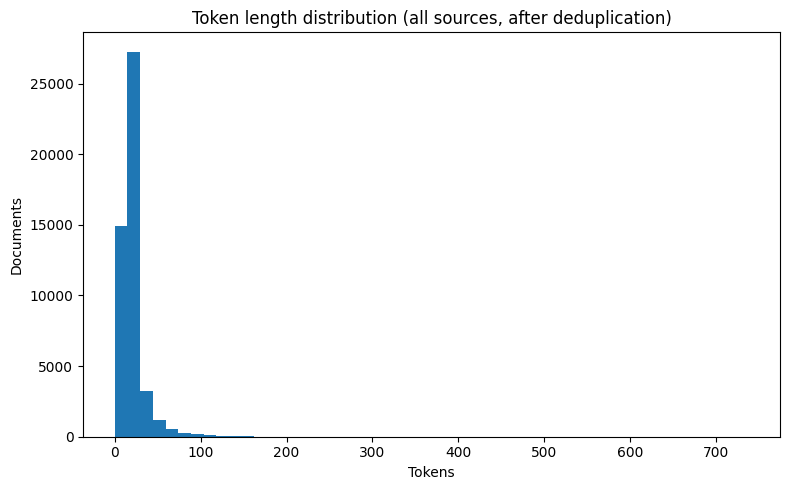


Top unigrams:
  token  count
   like   5245
 people   4352
   just   4054
    don   2949
  white   2886
  black   2789
fucking   2551
   know   2350
  women   2107
   want   1812
    man   1755
   time   1697
   feel   1693
  think   1613
   good   1603
  woman   1558
    say   1528
    did   1432
   make   1413
    got   1393
   girl   1299
    way   1286
 person   1259
   said   1234
    men   1190


In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) CONFIG: update these paths to DataFrame objects
# -----------------------------
PATHS = {}

# Conditionally add DataFrames to PATHS if they are defined
if 'self_MA' in globals():
    PATHS["selfma"] = self_MA
else:
    print("[WARN] 'self_MA' DataFrame not found. Skipping selfma dataset.")

if 'df_microagg_workplace' in globals():
    PATHS["workplacema"] = df_microagg_workplace
else:
    print("[WARN] 'df_microagg_workplace' DataFrame not found. Skipping workplacema dataset.")

if 'train_aggregated_df' in globals():
    PATHS["sbd"] = train_aggregated_df
else:
    print("[WARN] 'train_aggregated_df' DataFrame not found. Skipping sbd dataset.")

if 'df' in globals(): # Assuming 'df' is the ToxiGen DataFrame
    PATHS["toxigen"] = df
else:
    print("[WARN] 'df' (ToxiGen) DataFrame not found. Skipping toxigen dataset.")


# Dataset-specific label mapping overrides (edit if your columns/values differ)
OVERRIDES = {
    "workplacema": {  # maps to {microagg, non_agg}
        "label_col": "label", # Assuming 'label' is the column with 0/1 for microaggression
        "micro_values": {1}, # 1 indicates microaggression
        "non_values": {0}, # 0 indicates non-microaggression
    },
    "toxigen": {      # maps to {explicit_agg, non_agg}
        "label_col": "toxicity_human", # Using 'toxicity_human' for ToxiGen
        "explicit_values": {v for v in df['toxicity_human'].unique() if v >= 3} if 'df' in globals() and 'toxicity_human' in df.columns else set(), # Toxicity >= 3 is considered explicit_agg
        "non_values": {v for v in df['toxicity_human'].unique() if v < 3} if 'df' in globals() and 'toxicity_human' in df.columns else set(), # Toxicity < 3 is considered non_agg
    },
}

# candidate text columns if we need to guess
TEXT_CANDIDATES = [
    "text", "sentence", "content", "comment", "utterance", "body", "post", "tweet",
    "comment_text", "clean_text", "raw_text", "message", "speech"
]

SEED = 42
OUTDIR = Path("results")
OUTDIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 2) Helpers
# -----------------------------
def pick_text_col(df: pd.DataFrame) -> str:
    cols = set(c.lower() for c in df.columns)
    for c in TEXT_CANDIDATES:
        if c in cols:
            # return original case-sensitive name
            return [x for x in df.columns if x.lower() == c][0]
    # pick first object/string-like column
    for c in df.columns:
        if pd.api.types.is_string_dtype(df[c]):
            return c
    # otherwise force first column
    return df.columns[0]

def to_lower_str(x):
    try:
        return str(x).strip().lower()
    except Exception:
        return str(x)

def standardize(df_raw: pd.DataFrame, source: str) -> pd.DataFrame:
    txt_col = pick_text_col(df_raw)
    out = pd.DataFrame()
    out["text"] = df_raw[txt_col].astype(str)

    if source == "selfma":
        out["class"] = "microagg"

    elif source == "sbd":
        out["class"] = np.where(df_raw['offensiveYN'] >= 0.5, "explicit_agg", "non_agg")

    elif source == "toxigen":
        ov = OVERRIDES.get("toxigen", {})
        lab = ov.get("label_col")
        if lab and lab in df_raw.columns:
            # Convert numerical toxicity values to a boolean for explicit_agg
            out["class"] = np.where(df_raw[lab] >= 3, "explicit_agg", "non_agg")
        else:
            print(f"[WARN] ToxiGen label column '{lab}' not found (got columns: {list(df_raw.columns)[:8]}). Defaulting to non_agg.")
            out["class"] = "non_agg"

    elif source == "workplacema":
        ov = OVERRIDES.get("workplacema", {})
        lab = ov.get("label_col")
        if lab and lab in df_raw.columns:
            vals = df_raw[lab].map(to_lower_str)
            micro_set = {to_lower_str(str(v)) for v in ov.get("micro_values", set())}
            non_set = {to_lower_str(str(v)) for v in ov.get("non_values", set())}
            out["class"] = np.where(vals.isin(micro_set), "microagg",
                              np.where(vals.isin(non_set), "non_agg", "microagg"))
        else:
            print(f"[WARN] WorkplaceMA label column '{lab}' not found (got columns: {list(df_raw.columns)[:8]}). Defaulting to microagg.")
            out["class"] = "microagg"

    else:
        # unknown source \u2192 treat as non_agg so it won't inflate positives
        print(f"[WARN] Unknown source '{source}'. Marking as non_agg.")
        out["class"] = "non_agg"

    out["source"] = source
    out["text_norm"] = out["text"].str.strip().str.lower()
    out["n_tokens"] = out["text"].str.split().map(len).astype(int)
    out = out[["source", "text", "class", "n_tokens", "text_norm"]]
    out = out.dropna(subset=["text"])
    return out

# -----------------------------
# 3) Load, standardize, combine
# -----------------------------
frames = []
for src, df_obj in PATHS.items():
    if df_obj is None:
        print(f"[SKIP] {src}: DataFrame object is None.")
        continue
    try:
        df_std = standardize(df_obj, src)
        frames.append(df_std)
        print(f"[OK] Loaded {src}: {len(df_std):,} rows")
    except Exception as e:
        print(f"[ERROR] Failed to load {src}: {e}")

if not frames:
    raise SystemExit("No datasets could be loaded. Please ensure DataFrames are correctly assigned in PATHS.")

combined = pd.concat(frames, ignore_index=True)

# -----------------------------
# 4) Deduplicate & basic stats
# -----------------------------
n_before = len(combined)
dupes = combined.duplicated("text_norm").sum()
combined = combined.drop_duplicates("text_norm").drop(columns=["text_norm"])
n_after = len(combined)

# counts by source \u00D7 class
dataset_stats = (
    combined.groupby(["source", "class"])
            .size()
            .reset_index(name="n")
            .sort_values(["source", "class"])
)
overall_stats = (
    combined["class"].value_counts()
            .rename_axis("class").reset_index(name="n")
)

# token-length summary per source \u00D7 class
token_len = (
    combined.groupby(["source", "class"])["n_tokens"]
            .agg(["median", "mean", "std", "min", "max"])
            .reset_index()
            .sort_values(["source", "class"])
)

# -----------------------------
# 5) Save tables & print summary
# -----------------------------
OUTDIR.mkdir(exist_ok=True, parents=True)
dataset_stats.to_csv(OUTDIR / "table_dataset_stats.csv", index=False)
token_len.to_csv(OUTDIR / "table_token_lengths.csv", index=False)
overall_stats.to_csv(OUTDIR / "table_overall_class_balance.csv", index=False)

print("\n--- EDA SUMMARY ---")
print(f"Total docs BEFORE dedupe: {n_before:,}")
print(f"Duplicates removed:       {dupes:,}")
print(f"Total docs AFTER dedupe:  {n_after:,}")

print("\nCounts by source \u00D7 class:")
print(dataset_stats.to_string(index=False))

print("\nOverall class balance:")
print(overall_stats.to_string(index=False))

print("\nToken-length summary (by source \u00D7 class):")
print(token_len.to_string(index=False))

# -----------------------------
# 6) Figure 1: token-length histogram (all sources)
# -----------------------------
plt.figure(figsize=(8, 5))
plt.hist(combined["n_tokens"], bins=50)
plt.title("Token length distribution (all sources, after deduplication)")
plt.xlabel("Tokens")
plt.ylabel("Documents")
plt.tight_layout()
plt.savefig(OUTDIR / "fig_token_lengths.png", dpi=150)
plt.show()

# -----------------------------
# 7) Optional: quick top unigrams (sanity check)
# -----------------------------
try:
    from sklearn.feature_extraction.text import CountVectorizer
    cv = CountVectorizer(max_features=50, ngram_range=(1,1), stop_words="english")
    X = cv.fit_transform(combined["text"])
    freqs = pd.Series(np.asarray(X.sum(axis=0)).ravel(), index=cv.get_feature_names_out())
    top_uni = freqs.sort_values(ascending=False).head(25).reset_index()
    top_uni.columns = ["token", "count"]
    top_uni.to_csv(OUTDIR / "top_unigrams.csv", index=False)
    print("\nTop unigrams:")
    print(top_uni.to_string(index=False))
except Exception as e:
    print(f"[NOTE] Skipping top unigrams (scikit-learn may not be installed): {e}")